In [1]:
import numpy as np
import pandas as pd
import scvelo as scv #used for reading loom file
import anndata as ad
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib import rcParams # for changing the parameters of the scVelo figures
from sklearn.decomposition import PCA #for creating PCAs
from sklearn.preprocessing import StandardScaler #for creating PCAs
from scipy.spatial import cKDTree
import umap #for creating UMAP
import velocity

In [2]:
adata = ad.read_h5ad("anndata.h5ad")

In [3]:
sc.pp.pca(adata)
sc.pp.neighbors(adata, n_pcs = 30, n_neighbors = 30)

In [4]:
import scipy as sp
G_sp = adata.uns['neighbors']['distances']
adata.obsm["C"] = sp.sparse.csgraph.floyd_warshall(G_sp, directed = False)**2

In [5]:
np.save("C.npy", adata.obsm["C"])

AAACCCAGTGTTCATG-1-PBS    False
AAACGAACAAGTAGTA-1-PBS     True
AAACGAACACATTCTT-1-PBS    False
AAACGAACATGGAACG-1-PBS    False
AAACGAACATTCAGGT-1-PBS    False
                          ...  
TTTGATCTCAGTCTTT-1-PBS    False
TTTGGTTCATGACAGG-1-PBS    False
TTTGTTGAGCTAGATA-1-PBS    False
TTTGTTGCACTTGAAC-1-PBS    False
TTTGTTGCAGTTCACA-1-PBS    False
Name: original_clusters, Length: 2430, dtype: bool

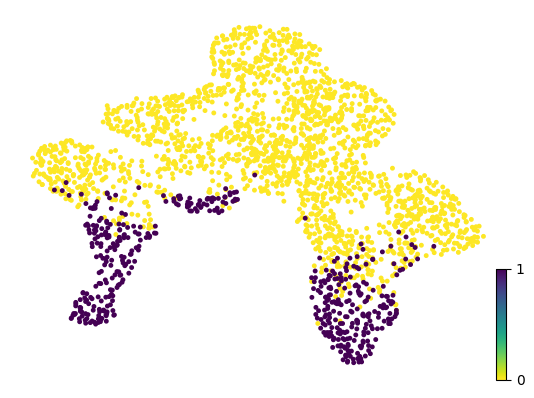

In [60]:
# Stationary OT
import statot
# C = sp.spatial.distance.cdist(adata.obsm["X_pca"], adata.obsm["X_pca"]);
C = adata.obsm["C"]
sink_idx = adata.obs.original_clusters.isin(["Myel. prog. #3", "Ery. prog. #2", "Eosinophil prog."])
R = np.zeros(adata.shape[0])
R[sink_idx] = -50/sum(sink_idx)
R[~sink_idx] = -R.sum()/sum(~sink_idx)
scv.pl.scatter(adata, color=sink_idx)

In [61]:
gamma, mu, nu = statot.inference.statot(adata.obsm["X_pca"], g = np.exp(R), dt = 1, C = C, eps = 0.25*C.mean(), method = "quad")
adata.obsm["P_statot"] = statot.inference.row_normalise(gamma)
np.save("P_statot.npy", adata.obsm["P_statot"])

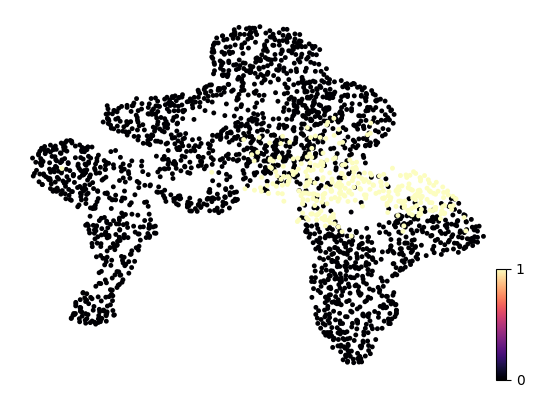

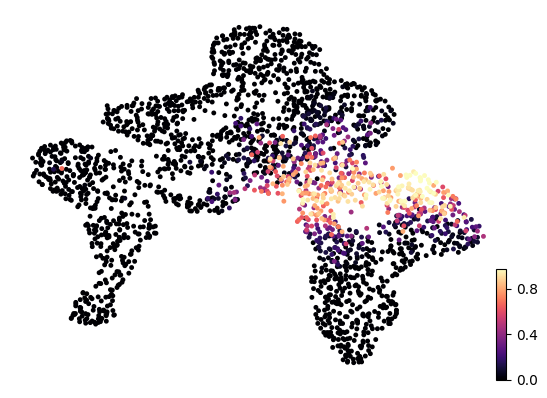

In [62]:
P = adata.obsm["P_statot"]
pi0 = np.array(adata.obs.original_clusters == "Myel. prog. #1")
pi1 = np.linalg.matrix_power(P, 1).T @ pi0
scv.pl.scatter(adata, color=pi0, color_map='magma')
scv.pl.scatter(adata, color=pi1, color_map='magma', vmin = 0)